In [143]:
import catboost as cb
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import shap
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#Making the dataset into a Pandas datafrome
boston=load_boston()
boston_dataset = pd.DataFrame(boston.data, columns=boston.feature_names)



In [144]:
#Reviewing the variables
boston_dataset.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [145]:
#What the dataset contains
print(boston_dataset.keys())

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')


In [146]:
#Assigning the target variable to the dataset
boston_dataset['MEDV'] = boston.target

In [147]:
#Checking for null values
boston_dataset.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

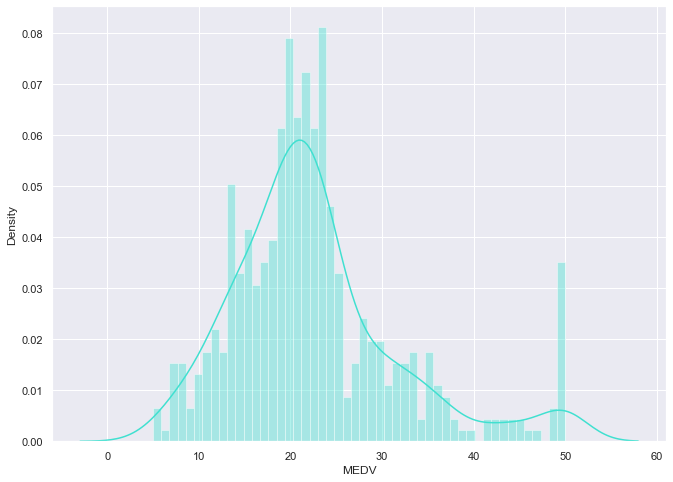

In [148]:
#Visualizing the target variable
sns.set(rc={'figure.figsize':(11,8)})
sns.distplot(boston_dataset['MEDV'], bins=50, color='turquoise')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax = plt.gca()
#ax.set_facecolor('black')
plt.show()

<AxesSubplot:>

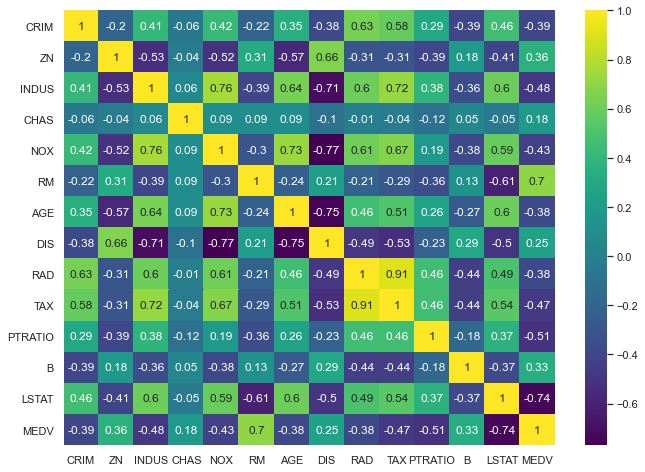

In [149]:
#Plotting a correlation plot between all preictors and the target variable (MEDV)
correlation_matrix = boston_dataset.corr().round(2)
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True, cmap = 'viridis')

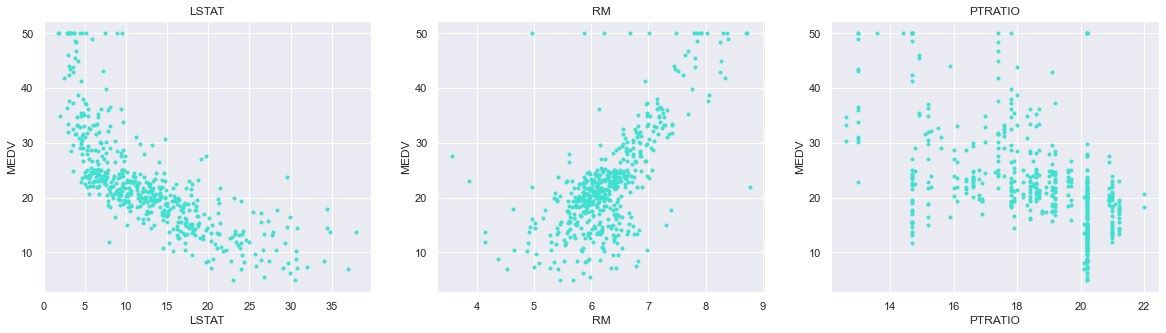

In [150]:
#Plotting the three most correlated variable with the target variable in descending order (MEDV)
plt.figure(figsize=(20, 5))

features = ['LSTAT', 'RM', 'PTRATIO']
target = boston_dataset['MEDV']

for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    x = boston_dataset[col]
    y = target
    plt.scatter(x, y, marker='.', color='turquoise')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('MEDV')

In [151]:
X, y = load_boston(return_X_y=True)

#Splitting the dataset into a train and test set with a predictor dataset and a target variable dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(404, 13)
(102, 13)
(404,)
(102,)


In [ ]:
#Creating a pool allows you to pinpoint target variables, predictors, and the list of categorical features, 
#while the pool constructor will combine those inputs and pass them to the model.
train_dataset = cb.Pool(X_train,y_train)                                                      
test_dataset = cb.Pool(X_test,y_test)

#Creating the model and using RMSE as a loss function because it's a regression task
model = cb.CatBoostRegressor(loss_function='RMSE')

#Grid for hyper parameter tuning
grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5,],
        'iterations': [50, 100, 150]}

#Training the model
model.grid_search(grid,train_dataset)

In [153]:
# model evaluation for training set
train_pred = model.predict(X_train)
train_rmse = (np.sqrt(mean_squared_error(y_train, train_pred)))
train_r2 = r2_score(y_train, train_pred)

print("The model performance for training set")
print("--------------------------------------")
print('RMSE is {:.2f}'.format(train_rmse))
print('R2 score is {:.2f}'.format(train_r2))
print("\n")

# model evaluation for testing set
pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)

print("The model performance for training set")
print("--------------------------------------")
print('RMSE is {:.2f}'.format(rmse))
print('R2 score is {:.2f}'.format(r2))
print("\n")

The model performance for training set
--------------------------------------
RMSE is 1.45
R2 score is 0.98


The model performance for training set
--------------------------------------
RMSE is 2.68
R2 score is 0.91




Text(0.5, 0, 'CatBoost Feature Importance')

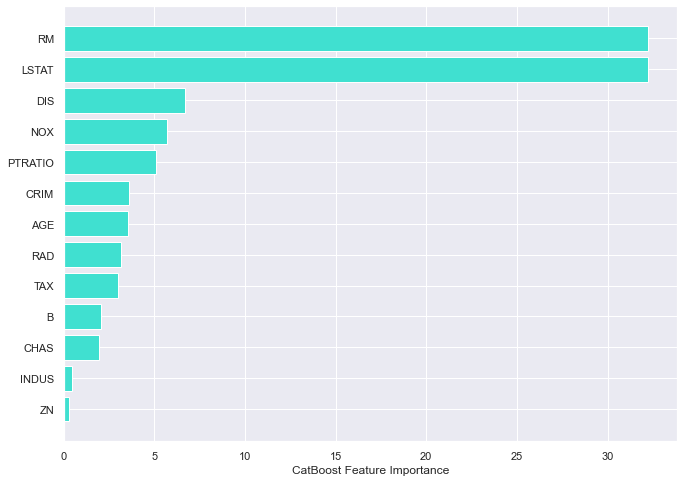

In [154]:
#Variable Importance Plot
sorted_feature_importance = model.feature_importances_.argsort()
plt.barh(boston.feature_names[sorted_feature_importance], 
        model.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

In [155]:
#SHAP Plots
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:])

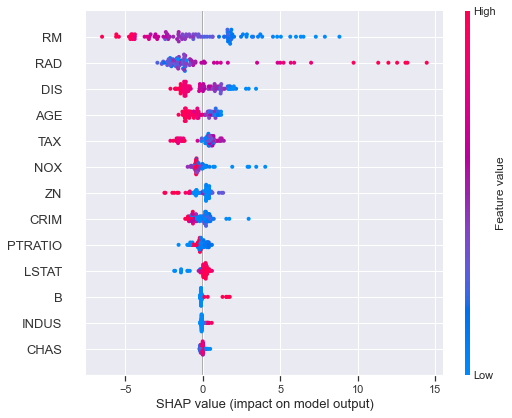

In [156]:
# summarize the effects of all the features
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names = boston.feature_names[sorted_feature_importance])